In [40]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch import optim
import numpy as np
import pandas as pd
import os
import io
import re
import sys
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
%matplotlib inline

In [42]:
processed_path = '../data/CSE-CIC-IDS2018/processed'
cleaned_csv_files = [
  '02-14-2018-bruteforce-ftp-ssh.csv',
  '02-15-2018-dos-goldeneye-slowloris.csv',
  '02-16-2018-dos-slowhttp-hulk.csv',
  '02-21-2018-ddos-loic-udp.csv',
  '02-22-2018-bruteforce-webxss.csv',
  '02-23-2018-bruteforce-webxss-sql.csv',
  '02-28-2018-infiltration.csv',
  '03-01-2018-botnet.csv',
  '03-02-2018-infiltration.csv'
  #'02-20-2018-ddos-loic-tcp.csv'   # WARNING: 4GB FILE.
]

list_of_dataframes = []
for filename in cleaned_csv_files:
    fname = os.path.join(processed_path, filename)
    list_of_dataframes.append(pd.read_csv(fname))

IDS_df = pd.concat(list_of_dataframes)

In [43]:
#IDS_df = pd.read_csv("../data/CSE-CIC-IDS2018/TRAINER-03-IDS-2018-multiclass.csv")

# To display the top 5 rows/
# IDS_df.head(5)
IDS_df.columns

Index(['dst_port', 'protocol', 'timestamp', 'flow_duration', 'tot_fwd_pkts',
       'tot_bwd_pkts', 'totlen_fwd_pkts', 'totlen_bwd_pkts', 'fwd_pkt_len_max',
       'fwd_pkt_len_min', 'fwd_pkt_len_mean', 'fwd_pkt_len_std',
       'bwd_pkt_len_max', 'bwd_pkt_len_min', 'bwd_pkt_len_mean',
       'bwd_pkt_len_std', 'flow_byts_s', 'flow_pkts_s', 'flow_iat_mean',
       'flow_iat_std', 'flow_iat_max', 'flow_iat_min', 'fwd_iat_tot',
       'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max', 'fwd_iat_min',
       'bwd_iat_tot', 'bwd_iat_mean', 'bwd_iat_std', 'bwd_iat_max',
       'bwd_iat_min', 'fwd_psh_flags', 'bwd_psh_flags', 'fwd_urg_flags',
       'bwd_urg_flags', 'fwd_header_len', 'bwd_header_len', 'fwd_pkts_s',
       'bwd_pkts_s', 'pkt_len_min', 'pkt_len_max', 'pkt_len_mean',
       'pkt_len_std', 'pkt_len_var', 'fin_flag_cnt', 'syn_flag_cnt',
       'rst_flag_cnt', 'psh_flag_cnt', 'ack_flag_cnt', 'urg_flag_cnt',
       'cwe_flag_count', 'ece_flag_cnt', 'down_up_ratio', 'pkt_size_avg',
      

In [44]:
IDS_df = IDS_df.drop('timestamp', axis=1)

In [45]:
for i in range(len(IDS_df.columns)):
     print(IDS_df.columns[i], '-', IDS_df.dtypes[i])

dst_port - int64
protocol - int64
flow_duration - int64
tot_fwd_pkts - int64
tot_bwd_pkts - int64
totlen_fwd_pkts - int64
totlen_bwd_pkts - float64
fwd_pkt_len_max - int64
fwd_pkt_len_min - int64
fwd_pkt_len_mean - float64
fwd_pkt_len_std - float64
bwd_pkt_len_max - int64
bwd_pkt_len_min - int64
bwd_pkt_len_mean - float64
bwd_pkt_len_std - float64
flow_byts_s - float64
flow_pkts_s - float64
flow_iat_mean - float64
flow_iat_std - float64
flow_iat_max - float64
flow_iat_min - float64
fwd_iat_tot - float64
fwd_iat_mean - float64
fwd_iat_std - float64
fwd_iat_max - float64
fwd_iat_min - float64
bwd_iat_tot - float64
bwd_iat_mean - float64
bwd_iat_std - float64
bwd_iat_max - float64
bwd_iat_min - float64
fwd_psh_flags - int64
bwd_psh_flags - int64
fwd_urg_flags - int64
bwd_urg_flags - int64
fwd_header_len - int64
bwd_header_len - int64
fwd_pkts_s - float64
bwd_pkts_s - float64
pkt_len_min - int64
pkt_len_max - int64
pkt_len_mean - float64
pkt_len_std - float64
pkt_len_var - float64
fin_flag

In [46]:
# print shape before dropping NaN rows
print(IDS_df.shape)

(8270842, 79)


In [47]:
# Finding the null values.
print(IDS_df.isin([np.nan, np.inf, -np.inf]).sum().sum())

45908


In [48]:
#  first replace infs to NaN:
IDS_df = IDS_df.replace([np.inf, -np.inf], np.nan)

In [49]:
# print shape after dropping NaN rows
IDS_df = IDS_df.dropna()
print(IDS_df.shape)
IDS_df = IDS_df.reset_index(drop=True)

(8247888, 79)


In [50]:
# Finding the null values.
print(IDS_df.isin([np.nan, np.inf, -np.inf]).sum().sum())

0


Examine the proportion of types of traffic:

In [51]:
IDS_df['label'].value_counts()

Benign                      6077145
DDOS attack-HOIC             686012
DoS attacks-Hulk             461912
Bot                          286191
FTP-BruteForce               193354
SSH-Bruteforce               187589
Infilteration                160639
DoS attacks-SlowHTTPTest     139890
DoS attacks-GoldenEye         41508
DoS attacks-Slowloris         10990
DDOS attack-LOIC-UDP           1730
Brute Force -Web                611
Brute Force -XSS                230
SQL Injection                    87
Name: label, dtype: int64

Convert all non-normal observations into a single class:

In [52]:
def get_label(text):    
    if text == "Benign":
        return 0
    elif text == 'Infilteration':
        return 1
    elif text == 'DoS attacks-Slowloris':
        return 2
    elif text == 'SSH-Bruteforce':
        return 3
    elif text == 'DDOS attack-HOIC':
        return 4
    elif text == 'FTP-BruteForce':
        return 5
    elif text == 'DoS attacks-SlowHTTPTest':
        return 6
    elif text == 'Bot':
        return 7
    elif text == 'DoS attacks-Hulk':
        return 8
    elif text == 'DoS attacks-GoldenEye':
        return 9
    elif text == 'DDoS attacks-LOIC-HTTP':
        return 10
    elif text == 'DDOS attack-LOIC-UDP':
        return 11
    elif text == 'Brute Force -Web':
        return 12
    elif text == 'Brute Force -XSS':
        return 13
    elif text == 'SQL Injection':
        return 14

IDS_df["label"] = IDS_df["label"].apply(get_label)

In [53]:
#y = IDS_df["Label"].values
print(IDS_df["label"].value_counts())

0     6077145
4      686012
8      461912
7      286191
5      193354
3      187589
1      160639
6      139890
9       41508
2       10990
11       1730
12        611
13        230
14         87
Name: label, dtype: int64


Convert all categorical features into numerical form:

In [54]:
from sklearn.preprocessing import LabelEncoder

encodings_dictionary = dict()
for c in IDS_df.columns:
    if IDS_df[c].dtype == "object":
        encodings_dictionary[c] = LabelEncoder()
        IDS_df[c] = encodings_dictionary[c].fit_transform(IDS_df[c])

Use Stratified K Fold to split the data into train and validation

In [55]:
seed = 1234
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state = seed)
target = IDS_df.loc[:,'label']

Train-test split the dataset:

In [56]:
def GetPyTorchDataLoaders(x_train, x_test, y_train, y_test, batch_size = 1000):
    # Pytorch
    X_train  = torch.from_numpy(x_train).float()
    Y_train = torch.from_numpy(y_train)

    X_test = torch.from_numpy(x_test).float()
    Y_test = torch.from_numpy(y_test)

    # Pytorch train and test sets
    train = torch.utils.data.TensorDataset(X_train, Y_train)
    valid = torch.utils.data.TensorDataset(X_test, Y_test)

    # data loader
    train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size = batch_size, shuffle = True)

    print('Completed loading data and returning pytorch train and validation data loaders')
    return train_loader, valid_loader

In [57]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
        
# Defining the DNN model
#input_size = train_loader.dataset.tensors[0].shape[1]
input_size = 78
hidden_layers = [256]
output_size = 15

# model definition
class MLP(nn.Module):
    # define model elements
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(n_inputs, hidden_layers[0])
        self.activ1 = nn.ReLU()
        
        #self.layer2 = nn.Linear(hidden_layers[0], hidden_layers[1])
        #self.activ2 = nn.ReLU()

        #self.layer3 = nn.Linear(hidden_layers[1], hidden_layers[2])
        #self.activ3 = nn.ReLU()
        
        self.layer2 = nn.Linear(hidden_layers[0], output_size)
        
    # forward propagate input
    def forward(self, x):
        x = self.layer1(x)
        x = self.activ1(x)
        
        #x = self.layer2(x)
        #x = self.activ2(x)
        
        #x = self.layer3(x)
        #x = self.activ3(x)
        
        x = self.layer2(x)
        return x

model = MLP(input_size)
print(model)
model.to(device)

 # Cross Entropy Loss 
error = nn.CrossEntropyLoss().to(device)
# Adam Optimizer
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)

MLP(
  (layer1): Linear(in_features=78, out_features=256, bias=True)
  (activ1): ReLU()
  (layer2): Linear(in_features=256, out_features=15, bias=True)
)


In [61]:
def train_model(train, test, fold_no):
    print('Start training...')
    start_time = time.time()

    epochs = 1

    count = 0
    loss_list = []
    iteration_list = []
    accuracy_list = []
    accuracy_scores = []
    
    # Separate into training data and labels, testing data and labels
    Y_train = train.pop("label").values
    X_train = train.values
    
    Y_test = test.pop("label").values
    X_test = test.values
    
    # Get PyTorch training and validation data loaders
    train_loader, valid_loader = GetPyTorchDataLoaders(X_train, X_test, Y_train, Y_test, batch_size = 1000)

    for e in range(epochs):
        correct_epoch = 0
        total_epoch = 0
        for i, (data, labels) in enumerate(train_loader):
            train = data.to(device)
            labels = labels.to(device)

            # Clear gradients
            optimizer.zero_grad()

            # Forward propagation
            outputs = model(train)

            # Calculate softmax and cross entropy loss
            loss = error(outputs, labels)

            # Calculating gradients
            loss.backward()

            # Update parameters
            optimizer.step()

            if count % 100 == 0:
                # Calculate Accuracy         
                correct = 0
                total = 0

                # Iterate through test dataset
                for data, labels in valid_loader:
                    valid = data.to(device)                               
                    labels = labels.to(device)

                    # Forward propagation
                    outputs = model(valid)

                    # Get predictions from the maximum value
                    predicted = torch.max(outputs.data, 1)[1]

                    #print('Predicted: ', predicted)

                    # Total number of labels
                    total += len(labels)
                    correct += (predicted == labels).sum()

                accuracy = 100 * correct / float(total)

                # store loss and iteration
                loss_list.append(loss.data)
                iteration_list.append(count)
                accuracy_list.append(accuracy)
                
            if count % 100 == 0:
                # Print Loss
                print('Epoch: {} Iteration: {}  Loss: {}  Accuracy: {} %'.format(e + 1, count, loss.data, accuracy))

            count += 1
        
        
        # calculate accuracy on the validation set
        # Iterate through test dataset
        for data, labels in valid_loader:
            valid = data.to(device)                               
            labels = labels.to(device)

            # Forward propagation
            outputs = model(valid)

            # Get predictions from the maximum value
            predicted = torch.max(outputs.data, 1)[1]
            
            total_epoch += len(labels)
            correct_epoch += (predicted == labels).sum()

        accuracy_epoch = (100 * correct_epoch / float(total_epoch)).item()

        print('Fold',str(fold_no), 'Epoch No. :', e, 'Accuracy for Epoch :', accuracy_epoch)

    end_time = time.time()
    accuracy_scores.append(accuracy_epoch)
    mean_accuracy_score = np.mean(accuracy_scores)
    print('Epochs completed. Time taken (seconds): ', str(end_time - start_time))
    print('Average accuracy over all epochs', mean_accuracy_score)
    return mean_accuracy_score
   

In [62]:
accuracy_scores = []
fold_no = 1

for train_index, test_index in skf.split(IDS_df, target):
    train = IDS_df.loc[train_index,:]
    test = IDS_df.loc[test_index,:]
    accuracy_score = train_model(train, test, fold_no)
    accuracy_scores.append(accuracy_score)
    fold_no += 1
    
print('Mean accuracy score across all cross validation sets', np.mean(accuracy_scores))

Start training...
Completed loading data and returning pytorch train and validation data loaders
Epoch: 1 Iteration: 0  Loss: 3099.1455078125  Accuracy: 84.47628021240234 %
Epoch: 1 Iteration: 100  Loss: 5265.826171875  Accuracy: 87.5980453491211 %
Epoch: 1 Iteration: 200  Loss: 6888.2958984375  Accuracy: 85.92149353027344 %
Epoch: 1 Iteration: 300  Loss: 8548.7060546875  Accuracy: 88.19576263427734 %
Epoch: 1 Iteration: 400  Loss: 3928.36572265625  Accuracy: 89.48458862304688 %
Epoch: 1 Iteration: 500  Loss: 15927.6259765625  Accuracy: 90.6816177368164 %
Epoch: 1 Iteration: 600  Loss: 8574.859375  Accuracy: 80.83631134033203 %
Epoch: 1 Iteration: 700  Loss: 2583.40771484375  Accuracy: 84.34617614746094 %
Epoch: 1 Iteration: 800  Loss: 1045.3656005859375  Accuracy: 88.74609375 %
Epoch: 1 Iteration: 900  Loss: 8936.9521484375  Accuracy: 88.21868133544922 %
Epoch: 1 Iteration: 1000  Loss: 7732.67431640625  Accuracy: 90.44943237304688 %
Epoch: 1 Iteration: 1100  Loss: 413.5671691894531  A

Epoch: 1 Iteration: 2300  Loss: 48.23068618774414  Accuracy: 88.14545440673828 %
Epoch: 1 Iteration: 2400  Loss: 239.0350799560547  Accuracy: 77.86100769042969 %
Epoch: 1 Iteration: 2500  Loss: 57.788543701171875  Accuracy: 91.75437927246094 %
Epoch: 1 Iteration: 2600  Loss: 82.55542755126953  Accuracy: 92.63799285888672 %
Epoch: 1 Iteration: 2700  Loss: 241.8072509765625  Accuracy: 89.44214630126953 %
Epoch: 1 Iteration: 2800  Loss: 146.3297119140625  Accuracy: 88.85871887207031 %
Epoch: 1 Iteration: 2900  Loss: 65.2767333984375  Accuracy: 84.23573303222656 %
Epoch: 1 Iteration: 3000  Loss: 226.13539123535156  Accuracy: 88.81932067871094 %
Epoch: 1 Iteration: 3100  Loss: 425.31732177734375  Accuracy: 89.09114837646484 %
Epoch: 1 Iteration: 3200  Loss: 148.29986572265625  Accuracy: 88.2982177734375 %
Epoch: 1 Iteration: 3300  Loss: 44.997886657714844  Accuracy: 85.72216796875 %
Epoch: 1 Iteration: 3400  Loss: 77.02788543701172  Accuracy: 87.55365753173828 %
Epoch: 1 Iteration: 3500  Lo

Epoch: 1 Iteration: 4600  Loss: 0.8243563175201416  Accuracy: 85.42730712890625 %
Epoch: 1 Iteration: 4700  Loss: 1.0387481451034546  Accuracy: 85.76205444335938 %
Epoch: 1 Iteration: 4800  Loss: 0.9244939684867859  Accuracy: 85.51666259765625 %
Epoch: 1 Iteration: 4900  Loss: 0.7424236536026001  Accuracy: 85.62905883789062 %
Epoch: 1 Iteration: 5000  Loss: 0.8620346784591675  Accuracy: 85.49957275390625 %
Epoch: 1 Iteration: 5100  Loss: 1.2680596113204956  Accuracy: 85.6833724975586 %
Epoch: 1 Iteration: 5200  Loss: 0.7059283256530762  Accuracy: 85.54794311523438 %
Epoch: 1 Iteration: 5300  Loss: 0.994006335735321  Accuracy: 85.51725769042969 %
Epoch: 1 Iteration: 5400  Loss: 1.8881635665893555  Accuracy: 85.5766830444336 %
Epoch: 1 Iteration: 5500  Loss: 1.1548585891723633  Accuracy: 85.3680191040039 %
Epoch: 1 Iteration: 5600  Loss: 1.0313204526901245  Accuracy: 86.90185546875 %
Epoch: 1 Iteration: 5700  Loss: 0.7402180433273315  Accuracy: 85.64323425292969 %
Epoch: 1 Iteration: 580

Epoch: 1 Iteration: 6900  Loss: 0.8206849694252014  Accuracy: 83.83271789550781 %
Epoch: 1 Iteration: 7000  Loss: 0.7813779711723328  Accuracy: 83.82046508789062 %
Epoch: 1 Iteration: 7100  Loss: 0.7686989307403564  Accuracy: 83.7747573852539 %
Epoch: 1 Iteration: 7200  Loss: 0.8110915422439575  Accuracy: 83.77633666992188 %
Epoch: 1 Iteration: 7300  Loss: 0.778888463973999  Accuracy: 83.73802185058594 %
Epoch: 1 Iteration: 7400  Loss: 0.7635128498077393  Accuracy: 83.46353149414062 %
Fold 4 Epoch No. : 0 Accuracy for Epoch : 83.58780670166016
Epochs completed. Time taken (seconds):  2119.765521287918
Average accuracy over all epochs 83.58780670166016
Start training...
Completed loading data and returning pytorch train and validation data loaders
Epoch: 1 Iteration: 0  Loss: 0.9112256765365601  Accuracy: 83.09906768798828 %
Epoch: 1 Iteration: 100  Loss: 0.7761479020118713  Accuracy: 83.8464126586914 %
Epoch: 1 Iteration: 200  Loss: 0.8017571568489075  Accuracy: 83.85816955566406 %
Epo

Epoch: 1 Iteration: 1400  Loss: 0.8165351152420044  Accuracy: 81.63348388671875 %
Epoch: 1 Iteration: 1500  Loss: 0.8563674092292786  Accuracy: 81.61190032958984 %
Epoch: 1 Iteration: 1600  Loss: 0.8337306976318359  Accuracy: 81.61759948730469 %
Epoch: 1 Iteration: 1700  Loss: 0.7716463208198547  Accuracy: 81.39936065673828 %
Epoch: 1 Iteration: 1800  Loss: 0.9267963767051697  Accuracy: 81.64512634277344 %
Epoch: 1 Iteration: 1900  Loss: 0.799351692199707  Accuracy: 81.64500427246094 %
Epoch: 1 Iteration: 2000  Loss: 0.9273772835731506  Accuracy: 81.64900207519531 %
Epoch: 1 Iteration: 2100  Loss: 0.8523193001747131  Accuracy: 81.62014770507812 %
Epoch: 1 Iteration: 2200  Loss: 0.8001448512077332  Accuracy: 81.64463806152344 %
Epoch: 1 Iteration: 2300  Loss: 0.8811419606208801  Accuracy: 81.61711120605469 %
Epoch: 1 Iteration: 2400  Loss: 0.9060463905334473  Accuracy: 81.64366912841797 %
Epoch: 1 Iteration: 2500  Loss: 0.7689059972763062  Accuracy: 81.6217269897461 %
Epoch: 1 Iteration

Epoch: 1 Iteration: 3700  Loss: 0.7534970641136169  Accuracy: 81.98035430908203 %
Epoch: 1 Iteration: 3800  Loss: 0.7926412224769592  Accuracy: 81.965087890625 %
Epoch: 1 Iteration: 3900  Loss: 0.9135222434997559  Accuracy: 81.982421875 %
Epoch: 1 Iteration: 4000  Loss: 0.8118467926979065  Accuracy: 81.97624206542969 %
Epoch: 1 Iteration: 4100  Loss: 0.8209523558616638  Accuracy: 81.94410705566406 %
Epoch: 1 Iteration: 4200  Loss: 0.8127445578575134  Accuracy: 81.97211456298828 %
Epoch: 1 Iteration: 4300  Loss: 0.838043212890625  Accuracy: 81.9795150756836 %
Epoch: 1 Iteration: 4400  Loss: 0.7965112328529358  Accuracy: 81.9779281616211 %
Epoch: 1 Iteration: 4500  Loss: 0.8579010963439941  Accuracy: 81.98193359375 %
Epoch: 1 Iteration: 4600  Loss: 0.8257718086242676  Accuracy: 81.97999572753906 %
Epoch: 1 Iteration: 4700  Loss: 0.8365787267684937  Accuracy: 81.97673034667969 %
Epoch: 1 Iteration: 4800  Loss: 0.8746343851089478  Accuracy: 81.98096466064453 %
Epoch: 1 Iteration: 4900  Los

Epoch: 1 Iteration: 6000  Loss: 0.8468315005302429  Accuracy: 81.60195922851562 %
Epoch: 1 Iteration: 6100  Loss: 0.8251774311065674  Accuracy: 81.53721618652344 %
Epoch: 1 Iteration: 6200  Loss: 0.8156551718711853  Accuracy: 81.57820129394531 %
Epoch: 1 Iteration: 6300  Loss: 0.8630697131156921  Accuracy: 81.45065307617188 %
Epoch: 1 Iteration: 6400  Loss: 0.8607076406478882  Accuracy: 81.55309295654297 %
Epoch: 1 Iteration: 6500  Loss: 0.8186013102531433  Accuracy: 81.49430084228516 %
Epoch: 1 Iteration: 6600  Loss: 0.9250956773757935  Accuracy: 81.48969268798828 %
Epoch: 1 Iteration: 6700  Loss: 0.8734655976295471  Accuracy: 81.50787353515625 %
Epoch: 1 Iteration: 6800  Loss: 0.8456119894981384  Accuracy: 81.56631469726562 %
Epoch: 1 Iteration: 6900  Loss: 0.8961796164512634  Accuracy: 81.57649993896484 %
Epoch: 1 Iteration: 7000  Loss: 0.8174991011619568  Accuracy: 81.56170654296875 %
Epoch: 1 Iteration: 7100  Loss: 0.8423861265182495  Accuracy: 81.58061981201172 %
Epoch: 1 Iterati

Epoch: 1 Iteration: 500  Loss: 0.7550186514854431  Accuracy: 81.88334655761719 %
Epoch: 1 Iteration: 600  Loss: 0.8378651142120361  Accuracy: 81.91826629638672 %
Epoch: 1 Iteration: 700  Loss: 0.7704294323921204  Accuracy: 81.89474487304688 %
Epoch: 1 Iteration: 800  Loss: 0.8259454369544983  Accuracy: 81.91220092773438 %
Epoch: 1 Iteration: 900  Loss: 0.7930015921592712  Accuracy: 81.92311096191406 %
Epoch: 1 Iteration: 1000  Loss: 0.8787292242050171  Accuracy: 81.91802215576172 %
Epoch: 1 Iteration: 1100  Loss: 0.8590245842933655  Accuracy: 81.90237426757812 %
Epoch: 1 Iteration: 1200  Loss: 0.8783048987388611  Accuracy: 81.92068481445312 %
Epoch: 1 Iteration: 1300  Loss: 0.8340209722518921  Accuracy: 81.87983703613281 %
Epoch: 1 Iteration: 1400  Loss: 0.9004214406013489  Accuracy: 81.89729309082031 %
Epoch: 1 Iteration: 1500  Loss: 0.8076409697532654  Accuracy: 81.88771057128906 %
Epoch: 1 Iteration: 1600  Loss: 0.8026077151298523  Accuracy: 81.91886138916016 %
Epoch: 1 Iteration: 1

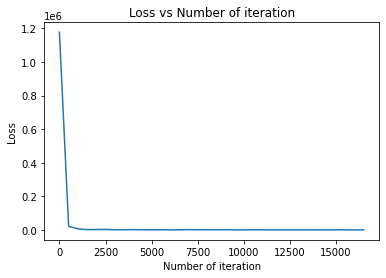

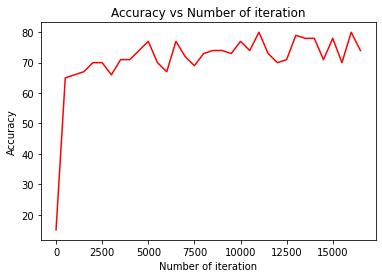

In [21]:
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of iteration")
plt.show()